In [1]:
!kaggle competitions download -c lab12-classification-problem

lab12-classification-problem.zip: Skipping, found more recently modified local copy (use --force to force download)


In [1]:
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import os
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [3]:
train = pd.read_csv('lab12-classification-problem/train.csv', sep=',')
test = pd.read_csv('lab12-classification-problem/test.csv', sep=',')

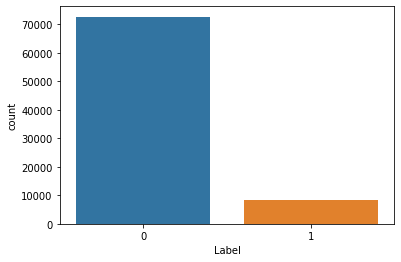

In [4]:
sns.countplot(x='Label', data=train)

In [5]:
train['Label'].value_counts()

0    72694
1     8432
Name: Label, dtype: int64

In [6]:
surnames = ['Алстон', 'Ампер', 'Андерсона', 'Байроне', 'Барда', 'Барнета', 'Бартом', 'Бартоном', 'Бедняков', 'Берлина', 'Бесов', 'Браге', 
  'Брауне', 'Городов', 'Джонс', 'Докторов', 'Духов', 'Дюпон', 'Жиров', 'Жуковский', 'Иванове', 'Ирвинг', 'Исаев', 'Кавалеров',
  'Кантом', 'Карманов', 'Каспера', 'Косова', 'Линкольнов', 'МУРАВЬЕВ', 'Мамедов', 'Монахов', 'Семенов', 'Эриксон']

non_surnames = set()

vc = train['Word'].value_counts()
doubled = [index for index in vc.index if vc[index] == 2]

for word in doubled:
    if word.islower():
        non_surnames.add(word)
    
set2_1_index = train[train['Word'].isin(list(surnames))].index
set2_0_index = train[train['Word'].isin(list(non_surnames))].index
train = train.set_value(set2_1_index, ['Label'], 1)
train = train.set_value(set2_0_index, ['Label'], 0)

## Hypothesis
* Заглавная буква у фамилий
* Окончания 
* первые буквы
* предпоследние буквы
* длина слова

In [7]:
target = 'Label'

In [8]:
def plot_pie(data, target, feature):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    data_0 = data[data[target] == 0][feature].value_counts()
    data_1 = data[data[target] == 1][feature].value_counts()

    axes[0].pie(data_0.values, labels=data_0.index.values)
    axes[1].pie(data_1.values, labels=data_1.index.values)
    
    axes[0].set_title(feature + ' | target 0')
    axes[1].set_title(feature + ' | target 1')

In [9]:
def is_only_capital(value):
    if value[0].isupper() and not value.isupper():
        return 1
    return 0

train['is_capital'] = train['Word'].map(lambda v: 1 if v[0].isupper() else 0)
train['is_all_capital'] = train['Word'].map(lambda v: 1 if v.isupper() else 0)
train['is_only_capital'] = train['Word'].map(is_only_capital)

test['is_capital'] = test['Word'].map(lambda v: 1 if v[0].isupper() else 0)
test['is_all_capital'] = test['Word'].map(lambda v: 1 if v.isupper() else 0)
test['is_only_capital'] = test['Word'].map(is_only_capital)

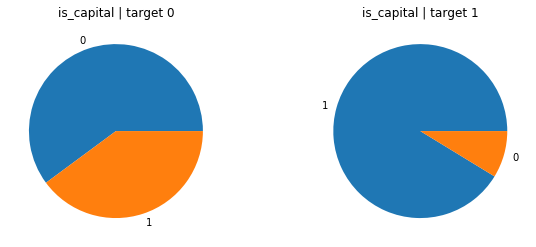

In [10]:
plot_pie(train, target, 'is_capital')

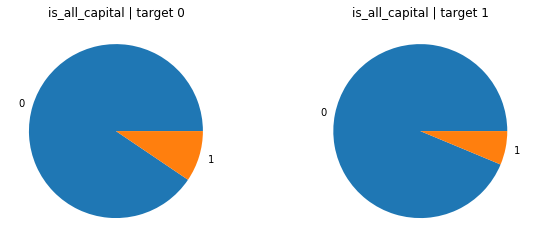

In [11]:
plot_pie(train, target, 'is_all_capital')

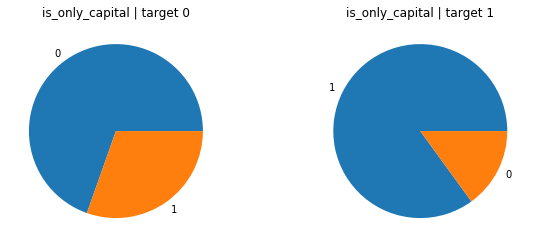

In [12]:
plot_pie(train, target, 'is_only_capital')

In [13]:
page = requests.get('http://imja.name/familii/pyatsot-chastykh-familij.shtml')
soup = BeautifulSoup(page.content, 'html.parser')

russian_surnames_endings = set([td.text[-2:] for td in soup.find_all("td", {"class": "topin1"})])

In [14]:
russian_surnames_endings.add('ева')
russian_surnames_endings.add('ова')
russian_surnames_endings.add('ина')
russian_surnames_endings.add('ына')
russian_surnames_endings

{'ев', 'ева', 'ий', 'ин', 'ина', 'ов', 'ова', 'ый', 'ын', 'ына', 'ых'}

In [15]:
def intersect(value):
    for el in list(russian_surnames_endings):
        if el in value[-3:]:
            return 1
    return 0

train['is_ru_ending'] = train['Word'].map(intersect)
test['is_ru_ending'] = test['Word'].map(intersect)

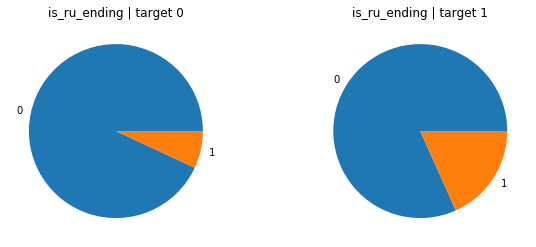

In [16]:
plot_pie(train, target, 'is_ru_ending')

In [17]:
import re

def contain(value, pattern):
    if re.findall(pattern, value):
        return 1
    return 0

In [18]:
vowels = 'аеёиоуыэюя'
consonants = 'бвгджзйклмнпрстфхчцшщъь'

all_letters = vowels + consonants

def count_vowels(value):
    return sum([value.lower().count(c) for c in vowels])

def count_consonants(value):
    return sum([value.lower().count(c) for c in consonants])

def get_letter_index(value, index):
    if len(value) > abs(index):
        return value[index].lower()
    return -1

train['first_letter'] = train['Word'].map(lambda v: v[0].lower())
test['first_letter'] = test['Word'].map(lambda v: v[0].lower())

train['second_letter'] = train['Word'].map(lambda v: get_letter_index(v, 1))
test['second_letter'] = test['Word'].map(lambda v: get_letter_index(v, 1))

train['last_letter'] = train['Word'].map(lambda v: v[-1].lower())
test['last_letter'] = test['Word'].map(lambda v: v[-1].lower())

train['pre_last_letter'] = train['Word'].map(lambda v: get_letter_index(v, -2))
test['pre_last_letter'] = test['Word'].map(lambda v: get_letter_index(v, -2))

train['pre_pre_last_letter'] = train['Word'].map(lambda v: get_letter_index(v, -3))
test['pre_pre_last_letter'] = test['Word'].map(lambda v: get_letter_index(v, -3))

train['word_len'] = train['Word'].map(lambda v: len(v))
test['word_len'] = test['Word'].map(lambda v: len(v))

train['n_vowels'] = train['Word'].map(count_vowels)
test['n_vowels'] = test['Word'].map(count_vowels)

train['n_consonants'] = train['Word'].map(count_consonants)
test['n_consonants'] = test['Word'].map(count_consonants)

train['contain_non_letter'] = train['Word'].map(lambda v: contain(v, '\W'))
test['contain_non_letter'] = test['Word'].map(lambda v: contain(v, '\W'))

train['contain_digit'] = train['Word'].map(lambda v: contain(v, '\d'))
test['contain_digit'] = test['Word'].map(lambda v: contain(v, '\d'))

In [19]:
prefixes = 'без-/бес-, в-/во-, воз-/вос-/возо-, вз-/вс-, вы-, до-, за-, из-/ис-/изо-, на-, наи-, недо-, над-/надо-, не-, низ-/нис-/низо-, о-, об-/обо-, обез-/обес-, от-/ото-, па-, пра, по-, под-/подо-, пере-, пре-, пред-/предо-, при-, про-, раз-/рас-/разо-, с-/со-, су-, через-/черес-/чрез- а-, ана-, анти-, архи-, гипер-, гипо-, де-, дез-, дис-, ин-, интер-, инфра-, квази-, кило-, контр-, макро-, микро-, мега-, мата-, мульти-, орто-, пан-, пара-, пост-, прото-, ре-, суб-, супер-, транс-, ультра-, зкстра-, экс-'
prefixes = prefixes.replace('-', '')
prefixes = prefixes.replace('/', ',')
prefixes = prefixes.replace(' ', '')
prefixes = prefixes.split(',')
prefixes = set([pref for pref in prefixes if len(pref) < 4])

def begin_with_prefix(word):
    return int(word[:3].lower() in prefixes)

train['begin_prefix'] = train['Word'].map(begin_with_prefix)
test['begin_prefix'] = test['Word'].map(begin_with_prefix)

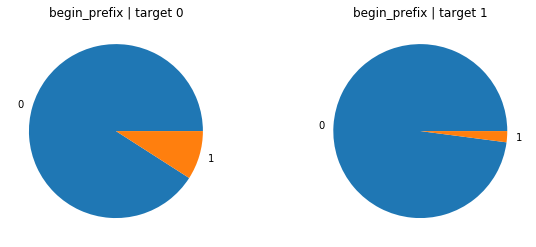

In [20]:
plot_pie(train, target, 'begin_prefix')

In [21]:
# train['is_capital_and_prefix'] = train['begin_prefix'] * train['is_capital']
# test['is_capital_and_prefix'] = test['begin_prefix'] * test['is_capital']

# plot_pie(train, target, 'is_capital_and_prefix')

In [22]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [23]:
train['normal'] = train['Word'].map(lambda v: morph.parse(v)[0].normal_form)
test['normal'] = test['Word'].map(lambda v: morph.parse(v)[0].normal_form)

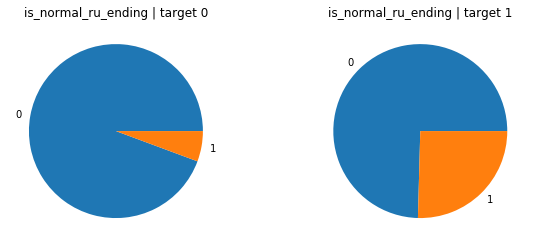

In [24]:
train['is_normal_ru_ending'] = train['normal'].map(intersect)
test['is_normal_ru_ending'] = train['normal'].map(intersect)
plot_pie(train, target, 'is_normal_ru_ending')

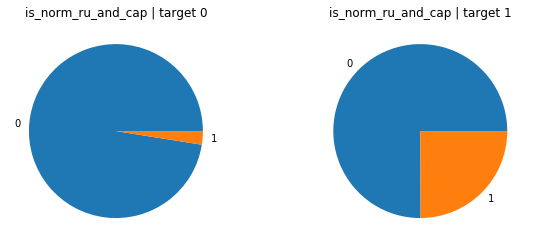

In [25]:
train['is_norm_ru_and_cap'] = train['is_normal_ru_ending'] * train['is_capital']
test['is_norm_ru_and_cap'] = test['is_normal_ru_ending'] * test['is_capital']

#train['is_norm_ru_only_and_cap'] = train['is_normal_ru_ending'] * train['is_only_capital']
#test['is_norm_ru_only_and_cap'] = test['is_normal_ru_ending'] * test['is_only_capital']

plot_pie(train, target, 'is_norm_ru_and_cap')
#plot_pie(train, target, 'is_norm_ru_only_and_cap')

In [26]:
from unicodedata import category, normalize

def unicode2ascii(s):
    return ''.join(
        c for c in normalize('NFD', s)
        if category(c) != 'Mn'
    )

unicode2ascii('тó')

'тo'

In [27]:
def clean(value):
    if value.isdigit():
        return ''
    if value[-1].isdigit():
        value = value[:-1]
    value = unicode2ascii(value)
    value = value.replace('/', '')
    value = value.replace('.', '')
    value = value.replace('”', '')
    value = value.replace('»', '')
    value = value.replace('·', '')
    value = value.replace('-', '')
    return value

train['normal'] = train['normal'].map(unicode2ascii)
test['normal'] = test['normal'].map(unicode2ascii)

train['normal_ending'] = train['normal'].map(lambda v: v[-2:])
train['normal_ending'] = train['normal_ending'].map(clean)
#train['normal'] = train['normal'].map(clean)

test['normal_ending'] = test['normal'].map(lambda v: v[-2:])
test['normal_ending'] = test['normal_ending'].map(clean)
#test['normal'] = test['normal'].map(clean)

In [29]:
#train['first_letter_normal'] = train['normal'].map(lambda v: v[0].lower())
#test['first_letter_normal'] = test['normal'].map(lambda v: v[0].lower())

#train['second_letter_normal'] = train['normal'].map(lambda v: get_letter_index(v, 1))
#test['second_letter_normal'] = test['normal'].map(lambda v: get_letter_index(v, 1))

train['last_letter_normal'] = train['normal'].map(lambda v: v[-1].lower())
test['last_letter_normal'] = test['normal'].map(lambda v: v[-1].lower())

train['pre_last_letter_normal'] = train['normal'].map(lambda v: get_letter_index(v, -2))
test['pre_last_letter_normal'] = test['normal'].map(lambda v: get_letter_index(v, -2))

train['pre_pre_last_letter_normal'] = train['normal'].map(lambda v: get_letter_index(v, -3))
test['pre_pre_last_letter_normal'] = test['normal'].map(lambda v: get_letter_index(v, -3))

In [29]:
#train['first_3'] = train['Word'].map(lambda v: v[:3])
#test['first_3'] = test['Word'].map(lambda v: v[:3])

In [28]:
def get_preusdo_root(value):
    if len(value) > 3:
        return value[1:4]
    return -1

train['pseudo_root'] = train['Word'].map(get_preusdo_root)
test['pseudo_root'] = test['Word'].map(get_preusdo_root)

In [30]:
attrs = ['POS', 'animacy', 'aspect', 'case', 'gender', 'involvement', 
         'mood', 'number', 'person', 'tense', 'transitivity', 'voice']

result = {attr: [] for attr in attrs}

def process(word, attrs):
    parsed = morph.parse(word)[0]
    for attr in attrs:
        value = getattr(parsed.tag, attr)
        if value is None:
            value = 'unknown'
        result[attr].append(value)

In [31]:
_ = train['Word'].map(lambda v: process(v, attrs))
r_train = pd.DataFrame.from_dict(result)

result = {attr: [] for attr in attrs}

_ = test['Word'].map(lambda v: process(v, attrs))
r_test = pd.DataFrame.from_dict(result)

In [32]:
train = train.merge(r_train, left_index=True, right_index=True)
test = test.merge(r_test, left_index=True, right_index=True)

In [33]:
train.head(1)

,Word,Label,is_capital,is_all_capital,is_only_capital,is_ru_ending,first_letter,second_letter,last_letter,pre_last_letter,pre_pre_last_letter,word_len,n_vowels,n_consonants,contain_non_letter,contain_digit,begin_prefix,normal,is_normal_ru_ending,is_norm_ru_and_cap,normal_ending,pseudo_root,last_letter_normal,pre_last_letter_normal,pre_pre_last_letter_normal,POS,animacy,aspect,case,gender,involvement,mood,number,person,tense,transitivity,voice
0,переброска,1,0,0,0,0,п,е,а,к,с,10,4,6,0,0,0,переброска,0,0,ка,ере,а,к,с,NOUN,inan,unknown,nomn,femn,unknown,unknown,sing,unknown,unknown,unknown,unknown


In [34]:
train.columns

Index(['Word', 'Label', 'is_capital', 'is_all_capital', 'is_only_capital',
       'is_ru_ending', 'first_letter', 'second_letter', 'last_letter',
       'pre_last_letter', 'pre_pre_last_letter', 'word_len', 'n_vowels',
       'n_consonants', 'contain_non_letter', 'contain_digit', 'begin_prefix',
       'normal', 'is_normal_ru_ending', 'is_norm_ru_and_cap', 'normal_ending',
       'pseudo_root', 'last_letter_normal', 'pre_last_letter_normal',
       'pre_pre_last_letter_normal', 'POS', 'animacy', 'aspect', 'case',
       'gender', 'involvement', 'mood', 'number', 'person', 'tense',
       'transitivity', 'voice'],
      dtype='object')

In [37]:
from sklearn.preprocessing import LabelEncoder
from copy import copy

feature2letter_encoder = {}

features_to_encode = ['first_letter', 'second_letter', 'last_letter', 'pre_last_letter', 'pre_pre_last_letter',
                      'normal_ending', 'last_letter_normal',
                      'pre_last_letter_normal', 'pre_pre_last_letter_normal', 'pseudo_root'] + attrs


all_data = pd.concat((train, test))

for feature in features_to_encode:
    all_data[feature] = all_data[feature].map(str)
    encoder = LabelEncoder().fit(all_data[feature])
    feature2letter_encoder[feature] = copy(encoder)

for feature in features_to_encode:
    train[feature] = feature2letter_encoder[feature].transform(train[feature].astype(str))
    test[feature] = feature2letter_encoder[feature].transform(test[feature].astype(str))

In [38]:
train.dtypes

Word                          object
Label                          int64
is_capital                     int64
is_all_capital                 int64
is_only_capital                int64
is_ru_ending                   int64
first_letter                   int32
second_letter                  int32
last_letter                    int32
pre_last_letter                int32
pre_pre_last_letter            int32
word_len                       int64
n_vowels                       int64
n_consonants                   int64
contain_non_letter             int64
contain_digit                  int64
begin_prefix                   int64
normal                        object
is_normal_ru_ending            int64
is_norm_ru_and_cap             int64
normal_ending                  int32
pseudo_root                    int32
last_letter_normal             int32
pre_last_letter_normal         int32
pre_pre_last_letter_normal     int32
POS                            int32
animacy                        int32
a

In [39]:
from copy import copy
from sklearn.model_selection import train_test_split

work_features = copy(train.columns.tolist())
work_features.remove('Word')
work_features.remove('Label')
work_features.remove('normal')
#work_features.remove('normal_ending')
#work_features.remove('pseudo_root')
#work_features.remove('is_ru_ending')
work_features.remove('begin_prefix')

X_train, X_test, y_train, y_test = train_test_split(train[work_features], train[target], shuffle=True, test_size=0.3)

cat_features = features_to_encode
print(cat_features)

#X_train.reset_index(inplace=True, drop=True)
#X_test.reset_index(inplace=True, drop=True)

#y_train.reset_index(inplace=True, drop=True)
#y_test.reset_index(inplace=True, drop=True)

['first_letter', 'second_letter', 'last_letter', 'pre_last_letter', 'pre_pre_last_letter', 'normal_ending', 'last_letter_normal', 'pre_last_letter_normal', 'pre_pre_last_letter_normal', 'pseudo_root', 'POS', 'animacy', 'aspect', 'case', 'gender', 'involvement', 'mood', 'number', 'person', 'tense', 'transitivity', 'voice']


In [40]:
# from sklearn.ensemble import RandomForestClassifier

# rand_forest_clf = RandomForestClassifier(n_estimators=250, verbose=1)
# rand_forest_clf.fit(X_train, y_train)

In [41]:
# y_pred_forest_proba = rand_forest_clf.predict_proba(X_test)[::,1]
# fpr, tpr, _ = roc_curve(y_test,  y_pred_forest_proba)
# auc = roc_auc_score(y_test, y_pred_forest_proba)
# plt.plot(fpr, tpr, label="auc="+str(auc))
# plt.plot([0, 1], [0, 1], '--')
# plt.legend(loc=4)
# plt.grid(True)
# plt.show()

In [42]:
# scores_forest = {}

# for thresold in linspace(0.001, 0.9, 1000):
#     y_pred_forest_proba_rounded = list(map(lambda v: 1 if v > thresold else 0, y_pred_forest_proba))
#     #scores[thresold] = f1_score(y_test, y_pred_rounded)
#     scores_forest[thresold] = roc_auc_score(y_test, y_pred_forest_proba_rounded)
    
# thresold_best_forest = sorted(scores_forest.items(), key=lambda kv: kv[1], reverse=True)[0][0]
# thresold_best_forest

In [43]:
# y_pred_forest_rounded = list(map(lambda v: 1 if v > thresold_best else 0, y_pred_forest_proba))

# print(roc_auc_score(y_test, y_pred_forest_rounded))
# print(f1_score(y_test, y_pred_forest_rounded))
# print(classification_report(y_test, y_pred_forest_rounded))
# _ = sns.heatmap(confusion_matrix(y_test, y_pred_forest_rounded), annot=True)

In [44]:
# from sklearn.model_selection import GridSearchCV

# forest_params = {
#     'n_estimators': [550, 650, 670],
#     'min_samples_split': [5, 6],
#     'min_samples_leaf': [5, 6]
# }

# grid_search_cv = GridSearchCV(cv=5, estimator=RandomForestClassifier(), 
#                               param_grid=forest_params, scoring='roc_auc', 
#                               verbose=1, n_jobs=4)

# grid_search_cv.fit(X_train, y_train)

In [45]:
# print(grid_search_cv.best_score_, grid_search_cv.best_params_)

# rand_forest_clf = RandomForestClassifier(**grid_search_cv.best_params_).fit(X_train, y_train)
# y_pred_forest_proba = rand_forest_clf.predict_proba(X_test)[:, 1]

# scores_forest = {}

# for thresold in linspace(0.001, 0.9, 1000):
#     y_pred_forest_proba_rounded = list(map(lambda v: 1 if v > thresold else 0, y_pred_forest_proba))
#     #scores[thresold] = f1_score(y_test, y_pred_rounded)
#     scores_forest[thresold] = roc_auc_score(y_test, y_pred_forest_proba_rounded)
    
# thresold_best_forest = sorted(scores_forest.items(), key=lambda kv: kv[1], reverse=True)[0][0]
# thresold_best_forest

In [46]:
# y_pred_forest_rounded = list(map(lambda v: 1 if v > thresold_best_forest else 0, y_pred_forest_proba))

# print(roc_auc_score(y_test, y_pred_forest_rounded))
# print(f1_score(y_test, y_pred_forest_rounded))
# print(classification_report(y_test, y_pred_forest_rounded))
# _ = sns.heatmap(confusion_matrix(y_test, y_pred_forest_rounded), annot=True)

In [47]:
# random_forest_labels = rand_forest_clf.predict_proba(train[work_features])[:, 1]
# random_forest_labels

In [49]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(learning_rate=0.07, depth=6, 
                           iterations=1000, eval_metric='AUC',
                           l2_leaf_reg=3,
                           thread_count=4,
                           cat_features=cat_features)

model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8497243	best: 0.8497243 (0)	total: 312ms	remaining: 5m 11s
1:	test: 0.8556904	best: 0.8556904 (1)	total: 520ms	remaining: 4m 19s
2:	test: 0.8707076	best: 0.8707076 (2)	total: 762ms	remaining: 4m 13s
3:	test: 0.8727001	best: 0.8727001 (3)	total: 968ms	remaining: 4m
4:	test: 0.8757105	best: 0.8757105 (4)	total: 1.25s	remaining: 4m 8s
5:	test: 0.8770406	best: 0.8770406 (5)	total: 1.5s	remaining: 4m 8s
6:	test: 0.8787787	best: 0.8787787 (6)	total: 1.72s	remaining: 4m 4s
7:	test: 0.8797998	best: 0.8797998 (7)	total: 1.91s	remaining: 3m 56s
8:	test: 0.8820275	best: 0.8820275 (8)	total: 2.15s	remaining: 3m 57s
9:	test: 0.8878919	best: 0.8878919 (9)	total: 2.35s	remaining: 3m 52s
10:	test: 0.8907392	best: 0.8907392 (10)	total: 2.55s	remaining: 3m 49s
11:	test: 0.8926980	best: 0.8926980 (11)	total: 2.76s	remaining: 3m 47s
12:	test: 0.8964863	best: 0.8964863 (12)	total: 2.97s	remaining: 3m 45s
13:	test: 0.8979591	best: 0.8979591 (13)	total: 3.18s	remaining: 3m 43s
14:	test: 0.8991331	

115:	test: 0.9452895	best: 0.9452895 (115)	total: 29s	remaining: 3m 40s
116:	test: 0.9453728	best: 0.9453728 (116)	total: 29.2s	remaining: 3m 40s
117:	test: 0.9453702	best: 0.9453728 (116)	total: 29.6s	remaining: 3m 40s
118:	test: 0.9453695	best: 0.9453728 (116)	total: 29.8s	remaining: 3m 40s
119:	test: 0.9453618	best: 0.9453728 (116)	total: 30s	remaining: 3m 40s
120:	test: 0.9454181	best: 0.9454181 (120)	total: 30.4s	remaining: 3m 40s
121:	test: 0.9454442	best: 0.9454442 (121)	total: 30.6s	remaining: 3m 40s
122:	test: 0.9461485	best: 0.9461485 (122)	total: 30.9s	remaining: 3m 40s
123:	test: 0.9461453	best: 0.9461485 (122)	total: 31.2s	remaining: 3m 40s
124:	test: 0.9461434	best: 0.9461485 (122)	total: 31.4s	remaining: 3m 39s
125:	test: 0.9461579	best: 0.9461579 (125)	total: 31.7s	remaining: 3m 39s
126:	test: 0.9461830	best: 0.9461830 (126)	total: 31.9s	remaining: 3m 39s
127:	test: 0.9461607	best: 0.9461830 (126)	total: 32.2s	remaining: 3m 39s
128:	test: 0.9462124	best: 0.9462124 (128)

227:	test: 0.9522249	best: 0.9522249 (227)	total: 1m	remaining: 3m 23s
228:	test: 0.9522409	best: 0.9522409 (228)	total: 1m	remaining: 3m 23s
229:	test: 0.9522320	best: 0.9522409 (228)	total: 1m	remaining: 3m 22s
230:	test: 0.9522695	best: 0.9522695 (230)	total: 1m	remaining: 3m 22s
231:	test: 0.9522876	best: 0.9522876 (231)	total: 1m 1s	remaining: 3m 22s
232:	test: 0.9522896	best: 0.9522896 (232)	total: 1m 1s	remaining: 3m 21s
233:	test: 0.9522873	best: 0.9522896 (232)	total: 1m 1s	remaining: 3m 21s
234:	test: 0.9523400	best: 0.9523400 (234)	total: 1m 1s	remaining: 3m 21s
235:	test: 0.9523445	best: 0.9523445 (235)	total: 1m 2s	remaining: 3m 20s
236:	test: 0.9523366	best: 0.9523445 (235)	total: 1m 2s	remaining: 3m 20s
237:	test: 0.9523824	best: 0.9523824 (237)	total: 1m 2s	remaining: 3m 20s
238:	test: 0.9524111	best: 0.9524111 (238)	total: 1m 2s	remaining: 3m 20s
239:	test: 0.9524157	best: 0.9524157 (239)	total: 1m 3s	remaining: 3m 19s
240:	test: 0.9524572	best: 0.9524572 (240)	total: 

338:	test: 0.9545617	best: 0.9545617 (338)	total: 1m 28s	remaining: 2m 53s
339:	test: 0.9545752	best: 0.9545752 (339)	total: 1m 29s	remaining: 2m 53s
340:	test: 0.9545953	best: 0.9545953 (340)	total: 1m 29s	remaining: 2m 53s
341:	test: 0.9545974	best: 0.9545974 (341)	total: 1m 29s	remaining: 2m 52s
342:	test: 0.9545892	best: 0.9545974 (341)	total: 1m 30s	remaining: 2m 52s
343:	test: 0.9545918	best: 0.9545974 (341)	total: 1m 30s	remaining: 2m 52s
344:	test: 0.9546341	best: 0.9546341 (344)	total: 1m 30s	remaining: 2m 51s
345:	test: 0.9546518	best: 0.9546518 (345)	total: 1m 30s	remaining: 2m 51s
346:	test: 0.9546561	best: 0.9546561 (346)	total: 1m 31s	remaining: 2m 51s
347:	test: 0.9546446	best: 0.9546561 (346)	total: 1m 31s	remaining: 2m 51s
348:	test: 0.9546468	best: 0.9546561 (346)	total: 1m 31s	remaining: 2m 50s
349:	test: 0.9546632	best: 0.9546632 (349)	total: 1m 31s	remaining: 2m 50s
350:	test: 0.9546724	best: 0.9546724 (350)	total: 1m 32s	remaining: 2m 50s
351:	test: 0.9546739	best

448:	test: 0.9561349	best: 0.9561349 (448)	total: 1m 57s	remaining: 2m 24s
449:	test: 0.9561506	best: 0.9561506 (449)	total: 1m 57s	remaining: 2m 24s
450:	test: 0.9561529	best: 0.9561529 (450)	total: 1m 58s	remaining: 2m 23s
451:	test: 0.9561831	best: 0.9561831 (451)	total: 1m 58s	remaining: 2m 23s
452:	test: 0.9561884	best: 0.9561884 (452)	total: 1m 58s	remaining: 2m 23s
453:	test: 0.9561852	best: 0.9561884 (452)	total: 1m 58s	remaining: 2m 23s
454:	test: 0.9561836	best: 0.9561884 (452)	total: 1m 59s	remaining: 2m 22s
455:	test: 0.9561951	best: 0.9561951 (455)	total: 1m 59s	remaining: 2m 22s
456:	test: 0.9561969	best: 0.9561969 (456)	total: 1m 59s	remaining: 2m 22s
457:	test: 0.9561968	best: 0.9561969 (456)	total: 2m	remaining: 2m 22s
458:	test: 0.9562038	best: 0.9562038 (458)	total: 2m	remaining: 2m 21s
459:	test: 0.9561967	best: 0.9562038 (458)	total: 2m	remaining: 2m 21s
460:	test: 0.9561867	best: 0.9562038 (458)	total: 2m	remaining: 2m 21s
461:	test: 0.9561756	best: 0.9562038 (458

559:	test: 0.9567549	best: 0.9567549 (559)	total: 2m 26s	remaining: 1m 54s
560:	test: 0.9567493	best: 0.9567549 (559)	total: 2m 26s	remaining: 1m 54s
561:	test: 0.9567519	best: 0.9567549 (559)	total: 2m 26s	remaining: 1m 54s
562:	test: 0.9567648	best: 0.9567648 (562)	total: 2m 26s	remaining: 1m 54s
563:	test: 0.9567624	best: 0.9567648 (562)	total: 2m 27s	remaining: 1m 53s
564:	test: 0.9567848	best: 0.9567848 (564)	total: 2m 27s	remaining: 1m 53s
565:	test: 0.9567820	best: 0.9567848 (564)	total: 2m 27s	remaining: 1m 53s
566:	test: 0.9567837	best: 0.9567848 (564)	total: 2m 27s	remaining: 1m 52s
567:	test: 0.9567912	best: 0.9567912 (567)	total: 2m 28s	remaining: 1m 52s
568:	test: 0.9568016	best: 0.9568016 (568)	total: 2m 28s	remaining: 1m 52s
569:	test: 0.9568002	best: 0.9568016 (568)	total: 2m 28s	remaining: 1m 52s
570:	test: 0.9568127	best: 0.9568127 (570)	total: 2m 29s	remaining: 1m 51s
571:	test: 0.9568331	best: 0.9568331 (571)	total: 2m 29s	remaining: 1m 51s
572:	test: 0.9568255	best

669:	test: 0.9574945	best: 0.9574945 (669)	total: 2m 58s	remaining: 1m 28s
670:	test: 0.9575009	best: 0.9575009 (670)	total: 2m 59s	remaining: 1m 27s
671:	test: 0.9575199	best: 0.9575199 (671)	total: 2m 59s	remaining: 1m 27s
672:	test: 0.9575083	best: 0.9575199 (671)	total: 2m 59s	remaining: 1m 27s
673:	test: 0.9575269	best: 0.9575269 (673)	total: 2m 59s	remaining: 1m 26s
674:	test: 0.9575336	best: 0.9575336 (674)	total: 3m	remaining: 1m 26s
675:	test: 0.9575417	best: 0.9575417 (675)	total: 3m	remaining: 1m 26s
676:	test: 0.9575420	best: 0.9575420 (676)	total: 3m	remaining: 1m 26s
677:	test: 0.9575376	best: 0.9575420 (676)	total: 3m	remaining: 1m 25s
678:	test: 0.9575424	best: 0.9575424 (678)	total: 3m 1s	remaining: 1m 25s
679:	test: 0.9575358	best: 0.9575424 (678)	total: 3m 1s	remaining: 1m 25s
680:	test: 0.9575404	best: 0.9575424 (678)	total: 3m 1s	remaining: 1m 25s
681:	test: 0.9575397	best: 0.9575424 (678)	total: 3m 2s	remaining: 1m 24s
682:	test: 0.9575550	best: 0.9575550 (682)	to

780:	test: 0.9577820	best: 0.9577920 (778)	total: 3m 30s	remaining: 59s
781:	test: 0.9577846	best: 0.9577920 (778)	total: 3m 30s	remaining: 58.8s
782:	test: 0.9577874	best: 0.9577920 (778)	total: 3m 31s	remaining: 58.5s
783:	test: 0.9577788	best: 0.9577920 (778)	total: 3m 31s	remaining: 58.2s
784:	test: 0.9577669	best: 0.9577920 (778)	total: 3m 31s	remaining: 58s
785:	test: 0.9577686	best: 0.9577920 (778)	total: 3m 31s	remaining: 57.7s
786:	test: 0.9577624	best: 0.9577920 (778)	total: 3m 32s	remaining: 57.4s
787:	test: 0.9577525	best: 0.9577920 (778)	total: 3m 32s	remaining: 57.1s
788:	test: 0.9577576	best: 0.9577920 (778)	total: 3m 32s	remaining: 56.9s
789:	test: 0.9577539	best: 0.9577920 (778)	total: 3m 33s	remaining: 56.6s
790:	test: 0.9577491	best: 0.9577920 (778)	total: 3m 33s	remaining: 56.3s
791:	test: 0.9577443	best: 0.9577920 (778)	total: 3m 33s	remaining: 56.1s
792:	test: 0.9577555	best: 0.9577920 (778)	total: 3m 33s	remaining: 55.8s
793:	test: 0.9577551	best: 0.9577920 (778)

892:	test: 0.9580889	best: 0.9581566 (878)	total: 4m 2s	remaining: 29.1s
893:	test: 0.9581052	best: 0.9581566 (878)	total: 4m 3s	remaining: 28.8s
894:	test: 0.9581106	best: 0.9581566 (878)	total: 4m 3s	remaining: 28.5s
895:	test: 0.9581199	best: 0.9581566 (878)	total: 4m 3s	remaining: 28.3s
896:	test: 0.9581291	best: 0.9581566 (878)	total: 4m 3s	remaining: 28s
897:	test: 0.9581270	best: 0.9581566 (878)	total: 4m 4s	remaining: 27.7s
898:	test: 0.9581223	best: 0.9581566 (878)	total: 4m 4s	remaining: 27.5s
899:	test: 0.9581526	best: 0.9581566 (878)	total: 4m 4s	remaining: 27.2s
900:	test: 0.9581518	best: 0.9581566 (878)	total: 4m 4s	remaining: 26.9s
901:	test: 0.9581366	best: 0.9581566 (878)	total: 4m 5s	remaining: 26.6s
902:	test: 0.9581244	best: 0.9581566 (878)	total: 4m 5s	remaining: 26.4s
903:	test: 0.9581126	best: 0.9581566 (878)	total: 4m 5s	remaining: 26.1s
904:	test: 0.9581139	best: 0.9581566 (878)	total: 4m 6s	remaining: 25.8s
905:	test: 0.9581208	best: 0.9581566 (878)	total: 4m 

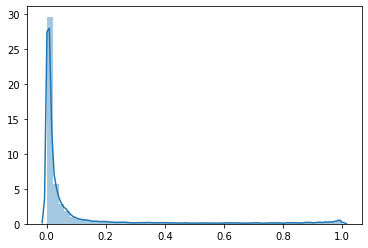

In [50]:
y_pred = model.predict_proba(X_test)[:, 1]
sns.distplot(y_pred)

In [51]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

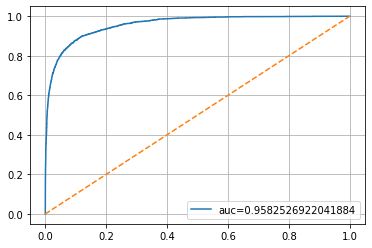

In [52]:
from sklearn.metrics import roc_curve

y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.plot([0, 1],[0, 1], '--')
plt.legend(loc=4)
plt.grid(True)
plt.show()

In [75]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from numpy import linspace

scores = {}

for thresold in linspace(0.01, 0.9, 1000):
    y_pred_rounded = list(map(lambda v: 1 if v > thresold else 0, y_pred))
    scores[thresold] = f1_score(y_test, y_pred_rounded)
    #scores[thresold] = roc_auc_score(y_test, y_pred_rounded)
    
thresold_best = sorted(scores.items(), key=lambda kv: kv[1], reverse=True)[0][0]
thresold_best

0.34764764764764766

0.7383863080684596
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     21848
           1       0.75      0.73      0.74      2490

    accuracy                           0.95     24338
   macro avg       0.86      0.85      0.85     24338
weighted avg       0.95      0.95      0.95     24338



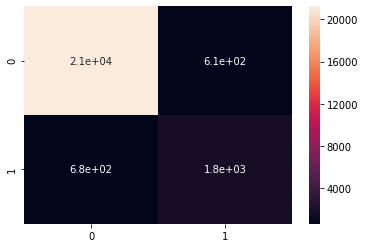

In [76]:
y_pred_rounded = list(map(lambda v: 1 if v > thresold_best else 0, y_pred))

print(f1_score(y_test, y_pred_rounded))
print(classification_report(y_test, y_pred_rounded))
_ = sns.heatmap(confusion_matrix(y_test, y_pred_rounded), annot=True)

In [55]:
from collections import OrderedDict
OrderedDict(sorted(dict(zip(model.feature_importances_, work_features)).items(), key=lambda kv: kv[0], reverse=True ))

OrderedDict([(15.173661323575729, 'is_capital'),
             (11.811597374356888, 'is_only_capital'),
             (11.574460968099725, 'case'),
             (8.845891460283994, 'normal_ending'),
             (6.324624765724281, 'pseudo_root'),
             (5.498906521926433, 'first_letter'),
             (4.576854696940431, 'last_letter'),
             (4.5262607396882535, 'n_vowels'),
             (3.6092568106658307, 'pre_pre_last_letter_normal'),
             (3.49668366844308, 'pre_last_letter'),
             (3.283077527384163, 'last_letter_normal'),
             (2.9488680687447677, 'animacy'),
             (2.5048706272347525, 'pre_pre_last_letter'),
             (2.3790810985890203, 'word_len'),
             (2.2800122386258046, 'second_letter'),
             (1.9288954336939506, 'pre_last_letter_normal'),
             (1.8129025013415647, 'is_norm_ru_and_cap'),
             (1.4869749133574344, 'gender'),
             (1.282907179546498, 'n_consonants'),
             (0.841

In [56]:
###!pip install bayesian-optimization

In [57]:
#from_train_to_test = set(train['Word'].values).intersection(set(test['Word'].values))

In [58]:
# def black_box_function(C):
#     kfold = KFold(n_splits=10, shuffle=False)
#     f1_scores = []
#     auc_scores = []

#     for train_index, test_index in kfold.split(X_train):
#         X_train_fold, X_test_fold = X_train.loc[train_index], X_train.loc[test_index]
#         y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

#         fold_log_reg = LogisticRegression(class_weight='balanced', C=C, max_iter=1000, n_jobs=-1)
#         fold_log_reg.fit(X_train_fold, y_train_fold)

#         y_pred_fold = fold_log_reg.predict_proba(X_test_fold)[:, 1]
#         y_pred_fold_rounded = list(map(lambda v: 1 if v > thresold_best else 0, y_pred_fold))
#         f1_scores.append(f1_score(y_test_fold, y_pred_fold_rounded))
#         auc_scores.append(roc_auc_score(y_test_fold, y_pred_fold_rounded))
#     return sum(auc_scores) / len(auc_scores)

In [59]:
# from bayes_opt import BayesianOptimization

# pbounds = {'C': (0, 3)}

# optimizer = BayesianOptimization(
#     f=black_box_function,
#     pbounds=pbounds,
#     random_state=1,
# )

# optimizer.maximize(
#     init_points=5,
#     n_iter=5,
# )

In [60]:
# import xgboost as xgb

# xgtrain = xgb.DMatrix(X_train, label=y_train)
# xgboost_clf = xgb.XGBClassifier(
#     max_depth = 7,
#     n_estimators=700,
#     learning_rate=0.05, 
#     nthread=4,
#     subsample=1.0,
#     colsample_bytree=0.5,
#     min_child_weight = 3)

# xgb_param = xgboost_clf.get_xgb_params()

In [61]:
# cv_result = xgb.cv(xgb_param, xgtrain, num_boost_round=5000, nfold=5, 
#                    metrics=['auc'], early_stopping_rounds=50, stratified=True)

# print('Best number of trees = {}'.format(cv_result.shape[0]))
# xgboost_clf.set_params(n_estimators=cv_result.shape[0])

In [62]:
#xgboost_clf.fit(X_train, y_train, eval_metric='auc')

In [63]:
# y_pred_xgboost = xgboost_clf.predict_proba(X_test)[:,1]
# xgb_scores = {}

# for thresold in linspace(0.001, 0.5, 1000):
#     y_pred_xgboost_rounded = list(map(lambda v: 1 if v > thresold else 0, y_pred_xgboost))
#     xgb_scores[thresold] = roc_auc_score(y_test, y_pred_xgboost_rounded)
    
# xgb_thresold_best = sorted(xgb_scores.items(), key=lambda kv: kv[1], reverse=True)[0][0]
# xgb_thresold_best

In [64]:
# y_pred_xgboost = xgboost_clf.predict_proba(X_test)[::,1]
# fpr, tpr, _ = roc_curve(y_test,  y_pred_xgboost)
# auc = roc_auc_score(y_test, y_pred_xgboost)
# plt.plot(fpr, tpr ,label="auc="+str(auc))
# plt.plot([0, 1],[0, 1], '--')
# plt.legend(loc=4)
# plt.grid(True)
# plt.show()

In [65]:
# from sklearn.linear_model import LogisticRegression

# xgboost_train_pred = xgboost_clf.predict_proba(X_train)[:, 1]
# xgboost_test_pred = xgboost_clf.predict_proba(X_test)[:, 1]

# catboost_train_pred = model.predict_proba(X_train)[:, 1]
# catboost_test_pred = model.predict_proba(X_test)[:, 1]

# X_train['xgb_preds'] = pd.Series(xgboost_train_pred, index=X_train.index)
# X_train['cb_preds'] = pd.Series(catboost_train_pred, index=X_train.index)

# X_test['xgb_preds'] = pd.Series(xgboost_test_pred, index=X_test.index)
# X_test['cb_preds'] = pd.Series(catboost_test_pred, index=X_test.index)

In [66]:
# log_reg = LogisticRegression(C=1., verbose=1, max_iter=1000)
# log_reg.fit(X_train, y_train)

In [67]:
# log_reg_preds = log_reg.predict_proba(X_test)[:, 1]

# fpr, tpr, _ = roc_curve(y_test,  log_reg_preds)
# auc = roc_auc_score(y_test, log_reg_preds)
# plt.plot(fpr, tpr ,label="auc="+str(auc))
# plt.plot([0, 1],[0, 1], '--')
# plt.legend(loc=4)
# plt.grid(True)
# plt.show()

In [68]:
# log_reg_preds = log_reg.predict_proba(X_test)[:, 1]
# log_reg_scores = {}

# for thresold in linspace(0.001, 0.5, 1000):
#     log_reg_preds_rounded = list(map(lambda v: 1 if v > thresold else 0, log_reg_preds))
#     log_reg_scores[thresold] = roc_auc_score(y_test, log_reg_preds_rounded)
    
# log_reg_thresold_best = sorted(log_reg_scores.items(), key=lambda kv: kv[1], reverse=True)[0][0]
# log_reg_thresold_best

In [69]:
#log_reg_preds_rounded = list(map(lambda v: 1 if v > log_reg_thresold_best else 0, log_reg_preds))

In [70]:
# print(roc_auc_score(y_test, log_reg_preds_rounded))
# print(f1_score(y_test, log_reg_preds_rounded))
# print(classification_report(y_test, log_reg_preds_rounded))
# _ = sns.heatmap(confusion_matrix(y_test, log_reg_preds_rounded), annot=True)

In [71]:
# work_features.remove('xgb_preds')
# work_features.remove('cb_preds')
# work_features

In [72]:
# xgb_test_all = xgboost_clf.predict_proba(test[work_features])[:, 1]
# cb_test_all = model.predict_proba(test[work_features])[:, 1]

# test['xgb_preds'] = pd.Series(xgb_test_all)
# test['cb_preds'] = pd.Series(cb_test_all)

# work_features.append('xgb_preds')
# work_features.append('cb_preds')

# y_pred = log_reg.predict_proba(test[work_features])[:, 1]
# y_pred_rounded = list(map(lambda v: 1 if v > log_reg_thresold_best else 0, y_pred))

In [73]:
y_test_pred = model.predict_proba(test[work_features])[:, 1]
#y_test_pred_round = list(map(lambda v: 1 if v > thresold_best else 0, y_test_pred))

pd.DataFrame.from_dict({'Id': test.index, 'Prediction': y_test_pred}).to_csv('submission.csv', index=False)